### Calculate the Word Mover's Distance between two sentences

In [1]:
import gensim.downloader as api
import glob
import sys
import os
import numpy as np
import pandas as pd

from tqdm import tqdm

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

### Read demographic groups' sentences

In [2]:
twitter_datapath = AbsolutePathBuilder.get_path(
    "04_twitter_scored",
    filepaths="../../../../config/filepaths.yaml"
)

filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(twitter_datapath, "*"))]

# Get the descriptions
data = []
for filename in filenames:
    description = {}
    
    description["filename"] = filename
    description["group"] = filename.split("_")[0]
    
    data.append(description)
    
df_data_desc = pd.DataFrame(data)

df_data_desc["group"] = (
    df_data_desc
    .group.apply(
        lambda group: "Black"
        if group=='aa'
        else "White"
    )
)

# Load data
dfs = []
for filename in df_data_desc[df_data_desc.group == "Black"].filename.values:
    try:
        df = pd.read_csv(os.path.join(twitter_datapath, filename))
        dfs.append(df)
    except:
        count += 1
df_black = pd.concat(dfs, ignore_index=True)

dfs = []
for filename in df_data_desc[df_data_desc.group == "White"].filename.values:
    try:
        df = pd.read_csv(os.path.join(twitter_datapath, filename))
        dfs.append(df)
    except:
        count += 1
df_white = pd.concat(dfs, ignore_index=True)

---
### Load embedding model

In [3]:
# https://github.com/RaRe-Technologies/gensim-data

embedding_model = api.load("glove-wiki-gigaword-50")

In [4]:
%%time

output_path = AbsolutePathBuilder.get_path(
    f"07_twitter_wmd",
    filepaths="../../../../config/filepaths.yaml"
)

file_idx = 0
data = []
distances = []
for idx, row_white in tqdm(df_white.iterrows(), total=df_white.shape[0]):
    closest_row_black = None
    closest_dist = np.inf
    for _, row_black in df_black.iterrows():
        cur_distance = embedding_model.wmdistance(row_white.text, row_black.text)

        if(cur_distance < closest_dist):
            closest_dist = cur_distance
            closest_row_black = row_black

    closest_row_black.index = [f"{name}_black" for name in closest_row_black.index]
    concatenated_row = pd.concat([closest_row_black, row_white])
    
    data.append(concatenated_row)
    distances.append(closest_dist)
    
    if ((idx+1) % 250 == 0) or (idx == df_white.index[-1]):
        df_wmd = pd.DataFrame(data)
        df_wmd = df_wmd.reset_index(drop=True)

        df_wmd["wmd"] = distances

        data.clear()
        distances.clear()
        df_wmd.to_csv(os.path.join(output_path, f"twitter_wmd_p{file_idx}.csv"), index=False)
        file_idx += 1

100%|███████████████████████████████████████████████████████████████| 250/250 [00:39<00:00,  6.30it/s]

CPU times: user 39.6 s, sys: 82.8 ms, total: 39.7 s
Wall time: 39.7 s


In [ ]:
1a

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


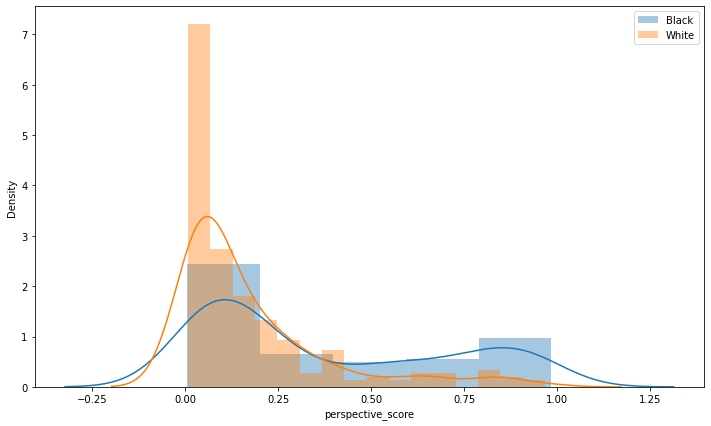

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12,7))

sns.distplot(df_wmd.perspective_score_black, label="Black")
sns.distplot(df_wmd.perspective_score, label="White")

plt.legend()
plt.show()

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


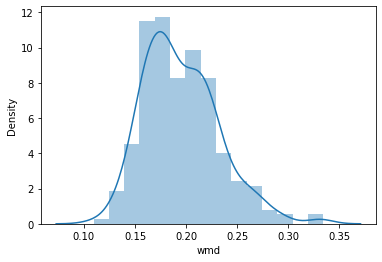

In [8]:
sns.distplot(df_wmd.wmd)
plt.title("")
plt.show()

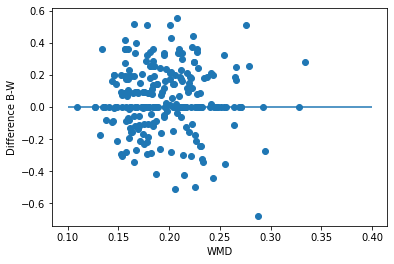

In [22]:
plt.scatter(df_wmd.wmd, df_wmd.vader_score_black - df_wmd.vader_score)

plt.xlabel("WMD")
plt.ylabel("Difference B-W")
plt.hlines(0, 0.1, 0.4)
plt.show()